In [ ]:
import json 
import os
import numpy as np

In [ ]:
#posenet
def truncate_objects(lst): 
  i = 0
  n = len(lst)-1

  while i<n: 
    while True: 
      if lst[i]['image'] != lst[i+1]['image']: 
        break
      else: 
        lst.remove(lst[i+1])
        n =n-1
    i = i+1
  
  return lst, len(lst)


def extract_keypoints_posenet(ld): 
  '''
  ld: list of dictionaries loaded from json file
  '''
  keypoints = []
  for i in range(len(ld)): 
    keypoints.append(ld[i]['keypoints'])
  
  keypoints = np.asarray(keypoints)
  
  return keypoints, keypoints.shape


def optimize_features(matrix): 
  '''
  Remove first 5 features
  rearrange order of rows in matrix (12,2)
  rearrange (y,x) -> (x,y)
  matrix: (909,17,2)
  '''
  new_matrix = []
  new_order_row = [11,9,7,6,8,10,5,3,1,0,2,4]
  new_order_column = [1,0]
  for i in range(matrix.shape[0]): 
    m = np.delete(matrix[i], np.s_[:5], 0) #remove 5 features
    m = ((m.T)[:, new_order_row]).T #rearrange rows
    m = m[:,new_order_column] #rearrange y,x -> x,y
    new_matrix.append(m)
  
  return np.asarray(new_matrix)


In [ ]:
#alphapose
def truncate_objects_alphpose(lsta): 
  i = 0
  n = len(lsta)-1

  while i<n: 
    while True: 
      if lsta[i]['image_id'] != lsta[i+1]['image_id']: 
        break
      else: 
        lsta.remove(lsta[i+1])
        n =n-1
    i = i+1
  
  return lsta, len(lsta)


def extract_keypoint_alphapose(lst_kp): 
  new = []
  for i in range(len(lst_kp)): 
    new.append(lst_kp[i]['keypoints'])
  
  new = np.asarray(new)
  return new, new.shape

def cvt_kp_for_alphapose_openpifpaf(lstkp): 
  lst_new = []
  for i in range(lstkp.shape[0]):
    pic = []
    for j in range(0, len(lstkp[i]), 3):
      pic.append([lstkp[i][j], lstkp[i][j+1]]) 
    lst_new.append(pic)
  
  lst_new = np.asarray(lst_new)
  return lst_new, lst_new.shape


def optimize_features_alphapose(matrix): 
  '''
  Remove first 5 features
  rearrange order of rows in matrix (12,2)
  rearrange (y,x) -> (x,y)
  matrix: (909,17,2)
  '''
  new_matrix = []
  new_order_row = [11,9,7,6,8,10,5,3,1,0,2,4]
  for i in range(matrix.shape[0]): 
    m = np.delete(matrix[i], np.s_[:5], 0) #remove 5 features
    m = ((m.T)[:, new_order_row]).T #rearrange rows
    new_matrix.append(m)
  
  return np.asarray(new_matrix)

In [ ]:
#posenet 

#load file 
f = open('/content/result.json')
data = json.load(f)

In [ ]:
#truncate the dupplicated object
data_new, len_data_new = truncate_objects(data)
print(len_data_new)

909


In [ ]:
#extract keypoint from json file
kp_coords, coords_shape = extract_keypoints_posenet(data_new)
coords_shape

(909, 17, 2)

In [ ]:
# remove the first 5 features, rearrange order of keypoints, rearange y,x to x,y
new_coords_keypoint = optimize_features(kp_coords)
new_coords_keypoint.shape

(909, 12, 2)

In [ ]:
#alphapose 

#load json file 
fa = open('/content/alphapose-results.json')
data_al = json.load(fa)
len(data_al)

1879

In [ ]:
#sort data_al 
data_sort = sorted(data_al, key = lambda k: k['image_id'])

In [ ]:
#truncate dupplicated objects 
data_trunc, data_trunc_len = truncate_objects_alphpose(data_sort)
data_trunc_len

912

In [ ]:
del data_trunc[:3]

In [ ]:
len(data_trunc)

909

In [ ]:
#extract keypoints 
kp_alpha, kp_alpha_shape = extract_keypoint_alphapose(data_trunc)
kp_alpha_shape

(909, 51)

In [ ]:
#cvt to 909 17 2
keypoints_al, keypoints_al_shape = cvt_kp_for_alphapose_openpifpaf(kp_alpha)
keypoints_al_shape

(909, 17, 2)

In [ ]:
#remove 5 5 features, rearrange order of keypoints
keypoints_al_op = optimize_features_alphapose(keypoints_al)
keypoints_al_op.shape

(909, 12, 2)

In [ ]:
def compute_Oks(label_kp, pred_kp, area, varr): 
  '''
  Compute Object keypoints similarity for each image

  params: 
    label_kp, pred_kp: label's/pred's keypoints (K, 2) where K: number of keypoints, 2: x and y
    area: height x weight of image. Because the dataset test cropped every single person in an image -> take the size of images as area
    varr: (sigmas*2)**2
  
  return: result of Oks in each image: e
  '''
  dx = pred_kp[:, 0] - label_kp[:,0]
  dy = pred_kp[:, 1] - label_kp[:, 1]

  e = (dx**2 + dy**2)/varr/(area + np.spacing(1))/2
  e = np.sum(np.exp(-e))/e.shape[0]

  return e

def sum_bool_PDJ(di, theta, w, h): 
  sum = 0
  for i in range(di.shape[0]): 
    if di[i] < theta*np.sqrt(w**2 + h**2): 
      sum +=1
  return sum

def compute_PDJ(label_kp, pred_kp, w, h,theta, n=12): 
  '''
  Compute PDJ 

  param: 
    label_kp, pred_kp: label's/pred's keypoints (K, 2) where K: number of keypoints, 2: x and y
    area: height x weight of image. Because the dataset test cropped every single person in an image -> take the size of images as area
  '''
  dx = pred_kp[:, 0] - label_kp[:,0]
  dy = pred_kp[:, 1] - label_kp[:, 1]

  di = dx**2 + dy**2 
  
  PDJ = sum_bool_PDJ(di, theta, w, h)/n
  return PDJ


In [ ]:
altext = open('/content/ALPHAPOSE.txt', 'r')
dataaltxt = altext.read()

In [ ]:
alsize = np.loadtxt('/content/alphasize.txt').reshape(909,2)
alsize.shape

(909, 2)

In [ ]:
dataaltxt = np.loadtxt('/content/ALPHAPOSE.txt').reshape(909,14,2)
dataaltxt.shape

(909, 14, 2)

In [ ]:
new_dataaltx = []

In [ ]:

for i in range(dataaltxt.shape[0]):
  m = np.delete(dataaltxt[i], np.s_[12:], 0)
  new_dataaltx.append(m)
new_dataaltx = np.asarray(new_dataaltx)
print(new_dataaltx.shape)

(909, 12, 2)


In [ ]:
new_dataaltx[0]

array([[ 28.12031897, 166.65510177],
       [ 49.17944312, 136.64584985],
       [ 62.60463477,  95.84379681],
       [ 80.24165125,  96.10703586],
       [ 91.56093048, 130.85459071],
       [ 78.39897788, 142.70034805],
       [ 61.28843951,  78.99649749],
       [ 49.96916028,  73.73171645],
       [ 63.92083003,  50.56667988],
       [ 98.66838488,  53.46230945],
       [111.30385937,  69.78313067],
       [109.46118601,  96.37027491]])

In [ ]:
alsize[0]

array([201., 145.])

In [ ]:
sigmas = np.array([.79, .79, .72, .72, .62, .62, 1.07, 1.07, .87,.87, .89, .89]) / 10.0
varr = (sigmas*2)**2

In [ ]:
OKS = []
for i in range(new_dataaltx.shape[0]): 
  oks = compute_Oks(new_dataaltx[i],keypoints_al_op[i],  alsize[i][0]*alsize[i][1],varr )
  OKS.append(oks)

In [ ]:
PDJ = []
for i in range(new_dataaltx.shape[0]): 
  pdj = compute_PDJ(new_dataaltx[i], keypoints_al_op[i], alsize[i][0], alsize[i][1], 0.1)
  PDJ.append(pdj)
PDJ_a = np.asarray(PDJ)
print(len(PDJ))
print(np.sum(PDJ_a)/len(PDJ))

909
0.8362669600293363


In [ ]:
OKS_a = np.asarray(OKS)

In [ ]:
len(OKS)

909

In [ ]:
oks_score = np.sum(OKS_a)/len(OKS)
oks_score

0.971088553719786

In [ ]:
posetxt = np.loadtxt('/content/POSE_NET.txt').reshape(909, 14, 2)
psize = np.loadtxt('/content/posesize.txt').reshape(909,2)
print(posetxt.shape)
print(psize.shape)

(909, 14, 2)
(909, 2)


In [ ]:
newp = []
for i in range(posetxt.shape[0]):
  m = np.delete(posetxt[i], np.s_[12:], 0)
  newp.append(m)
newp = np.asarray(newp)
print(newp.shape)

(909, 12, 2)


In [ ]:
OKS_p = []
for i in range(posetxt.shape[0]):
  oks_p = compute_Oks(newp[i], new_coords_keypoint[i], psize[i][0]*psize[i][1], varr )
  OKS_p.append(oks_p)
OKS_pa = np.asarray(OKS_p)
print(len(OKS_p))

909


In [ ]:
PDJ_p = []
for i in range(posetxt.shape[0]): 
  pdj_p = compute_PDJ(newp[i], new_coords_keypoint[i], psize[i][0], psize[i][1], 0.5)
  PDJ_p.append(pdj_p)
PDJ_pa = np.asarray(PDJ_p)
print(len(PDJ_p))
print(np.sum(PDJ_pa)/len(PDJ_p))

909
0.7072790612394573


In [ ]:
OKS_p_score = np.sum(OKS_pa)/len(OKS_p)
OKS_p_score

0.8635762325999012

In [ ]:
print("min value of posenet (OKS): {0}, max value of posenet (OKS): {1}".format(min(OKS_p), max(OKS_p)))

min value of posenet (OKS): 0.010397430333946524, max value of posenet (OKS): 0.9910770691784178


In [ ]:
print("min value of ALPHAPOSE (OKS): {0}, max value of ALPHAPOSE (OKS): {1}".format(min(OKS), max(OKS)))

min value of ALPHAPOSE (OKS): 0.022725756862861143, max value of ALPHAPOSE (OKS): 0.9981942266777418


In [ ]:
print("min value of posenet (PDJ): {0}, max value of posenet (PDJ): {1}".format(min(PDJ_p), max(PDJ_p)))

min value of posenet (PDJ): 0.0, max value of posenet (PDJ): 1.0


In [ ]:
print("min value of ALPHAPOSE (PDJ): {0}, max value of ALPHAPOSE (PDJ): {1}".format(min(PDJ), max(PDJ)))

min value of ALPHAPOSE (PDJ): 0.0, max value of ALPHAPOSE (PDJ): 1.0


In [ ]:
import matplotlib.pyplot as plt


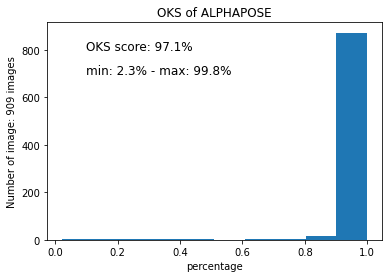

In [ ]:
counts, bins = np.histogram(OKS_a)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('OKS of ALPHAPOSE')
plt.xlabel('percentage')
plt.ylabel('Number of image: 909 images')
plt.text(.1,800, 'OKS score: {}%'.format(97.1), fontsize=12)
plt.text(.1,700, 'min: {0}% - max: {1}%'.format(2.3, 99.8), fontsize=12)
plt.savefig('OKSofAlphapose.png')

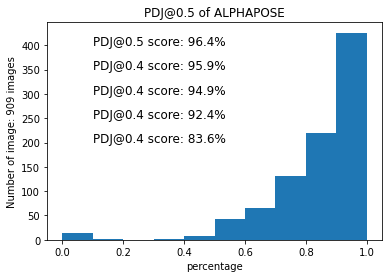

In [ ]:
countsPDJ, binsPDJ = np.histogram(PDJ_a)
plt.hist(binsPDJ[:-1], binsPDJ, weights=countsPDJ)
plt.title('PDJ@0.5 of ALPHAPOSE')
plt.xlabel('percentage')
plt.ylabel('Number of image: 909 images')
plt.text(.1,400, 'PDJ@0.5 score: {}%'.format(96.4), fontsize=12)
plt.text(.1,350, 'PDJ@0.4 score: {}%'.format(95.9), fontsize=12)
plt.text(.1,300, 'PDJ@0.4 score: {}%'.format(94.9), fontsize=12)
plt.text(.1,250, 'PDJ@0.4 score: {}%'.format(92.4), fontsize=12)
plt.text(.1,200, 'PDJ@0.4 score: {}%'.format(83.6), fontsize=12)
plt.savefig('PDJ@05ofAlphapose.png')

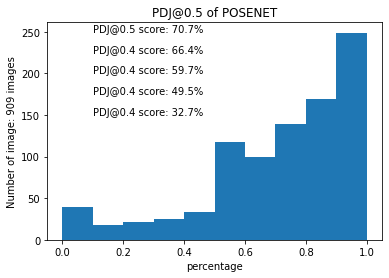

In [ ]:
countsPDJp, binsPDJp = np.histogram(PDJ_p)
plt.hist(binsPDJp[:-1], binsPDJp, weights=countsPDJp)
plt.title('PDJ@0.5 of POSENET')
plt.xlabel('percentage')
plt.ylabel('Number of image: 909 images')
plt.text(.1,250, 'PDJ@0.5 score: {}%'.format(70.7), fontsize=10)
plt.text(.1,225, 'PDJ@0.4 score: {}%'.format(66.4), fontsize=10)
plt.text(.1,200, 'PDJ@0.4 score: {}%'.format(59.7), fontsize=10)
plt.text(.1,175, 'PDJ@0.4 score: {}%'.format(49.5), fontsize=10)
plt.text(.1,150, 'PDJ@0.4 score: {}%'.format(32.7), fontsize=10)
plt.savefig('PDJ@05ofposenet.png')

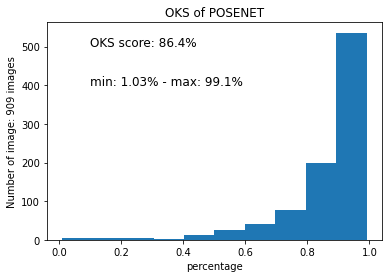

In [ ]:
countsOKSp, binsOKSp = np.histogram(OKS_pa)
plt.hist(binsOKSp[:-1], binsOKSp, weights=countsOKSp)
plt.title('OKS of POSENET')
plt.xlabel('percentage')
plt.ylabel('Number of image: 909 images')
plt.text(.1,500, 'OKS score: {}%'.format(86.4), fontsize=12)
plt.text(.1,400, 'min: {0}% - max: {1}%'.format(1.03, 99.1), fontsize=12)
plt.savefig('OKSofposenet.png')